# GP Classification Model 

This notebook is an example of how the GP models were constructued and trained. 
Building, training, testing, and analyzing models is an iterative process in the drug discovery space, so  
this notebook also produces some of the visualizations included in the final report and/or presentation 

In [1]:
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from imports import *

# Model
- Dirichlet exact GP that uses exact inference
- use a constant mean
- RBF kernel for the covariance function 

In [2]:
# Construct a GP classification model
# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# Trainer class 

In [3]:
class Trainer: 
    def __init__(self,model, likelihood, iterations): 
        self.model = model
        self.likelihood = likelihood 

        smoke_test = ('CI' in os.environ)
        self.n_iterations = 2 if smoke_test else iterations
        # self.n_iterations = n_iterations 
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        # loss function 
        self.loss_fn = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)
    def train(self, train_x, train_y): 
        self.model.train()
        self.likelihood.train()
        predictions = [] 
        for i in range(self.n_iterations): 
            self.optimizer.zero_grad()
            output = self.model(train_x)
            loss = -self.loss_fn(output, self.likelihood.transformed_targets).sum()
            loss.backward()
            if (i%10==0): 
                print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                    i + 1, self.n_iterations, loss.item(),
                    self.model.covar_module.base_kernel.lengthscale.mean().item(),
                    self.model.likelihood.second_noise_covar.noise.mean().item()
                ))
             
          
            self.optimizer.step() 


    def predict(self, input): 
        self.model.eval()
        self.likelihood.eval()

        with gpytorch.settings.fast_pred_var(), torch.no_grad():
            dist = self.model(input)     # output distribution
            pred_means = dist.loc          # means of distributino 
            # f_samples = dist.sample(sample_shape=torch.Size(1000))    
            observed_pred = self.likelihood(self.model(input))    # likelihood predictions mean and var  
            # class_pred = self.model(input).loc.max(0)[1].numpy()  # predictions (0 or 1) 
            class_pred = self.model(input).loc.max(0)[1]
            
        return dist, observed_pred, pred_means,class_pred
    

    def evaluate(self, x_input, y_true): 
        y_pred = self.model(x_input).loc.max(0)[1].numpy()
        
        return y_pred

    def gp_results(self, x_input, y_true, plot_title): 
        y_pred = self.evaluate(x_input, y_true) 
        if isinstance(y_true, torch.Tensor):
            y_true = y_true.numpy().reshape(-1)
        plot_confusion_matrix(y_true, y_pred, ['0','1'], title=plot_title)
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        dist = self.model(x_input)     # get predicted distributions 
        pred_means = dist.loc          # means for predicted dist  

        recall = recall_score(y_true, y_pred)
        tp, tn, fp, fn = calculate_metrics(y_true, y_pred) 
        sensitivity = tp / (tp + fn) 
        specificity = tn / (tn + fp) 
        print(f'accuracy: {accuracy:.4f}, precision: {precision:.4f}, recall: {recall:.4f}, specificity: {specificity:.4f}')
        return {'accuracy': accuracy, 'precision': precision,  'recall':recall, 'specificity':specificity}

       

# Load the data 

Here, I will demonstrate with the binding undersampled data 
We load in the previously split data we treated with SMOTE
- Load in the split files and conver to torch tensors

In [4]:
split_path = '../data/binding/splits/'
train_x_df_temp = pd.read_csv(split_path+"bind_train_x_UNDER.csv",header=None)
train_y_df_temp = pd.read_csv(split_path+"bind_train_y_UNDER.csv",header=None)
test_x_df = pd.read_csv(split_path+"bind_test_x_UNDER.csv",header=None)
test_y_df = pd.read_csv(split_path+"bind_test_y_UNDER.csv",header=None)

train_x_temp = train_x_df_temp.to_numpy().astype("long")
test_x_temp = test_x_df.to_numpy().astype("long")

train_y_temp = train_y_df_temp.to_numpy().flatten().astype("long")
test_y_temp = test_y_df.to_numpy().flatten().astype("long")

train_x = torch.from_numpy(train_x_temp)
train_y = torch.from_numpy(train_y_temp)
test_x = torch.from_numpy(test_x_temp)
test_y = torch.from_numpy(test_y_temp)


print(train_x.shape) 
print(train_y.shape) 


torch.Size([90, 306])
torch.Size([90])


In [5]:
# Define the likelihood, and other parameters 
likelihood1 = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model1 = DirichletGPModel(train_x, likelihood1.transformed_targets, likelihood1, num_classes=likelihood1.num_classes)
n_iterations = 300
trainer1 = Trainer(model1, likelihood1, n_iterations)
trainer1.train(train_x, train_y) 

Iter 1/300 - Loss: 7.107   lengthscale: 0.693   noise: 0.693
Iter 11/300 - Loss: 5.931   lengthscale: 0.887   noise: 1.297
Iter 21/300 - Loss: 5.439   lengthscale: 1.231   noise: 1.982
Iter 31/300 - Loss: 5.260   lengthscale: 1.916   noise: 2.573
Iter 41/300 - Loss: 5.186   lengthscale: 2.967   noise: 3.003
Iter 51/300 - Loss: 5.154   lengthscale: 4.206   noise: 3.277
Iter 61/300 - Loss: 5.128   lengthscale: 5.280   noise: 3.415
Iter 71/300 - Loss: 5.117   lengthscale: 5.922   noise: 3.431
Iter 81/300 - Loss: 5.111   lengthscale: 6.066   noise: 3.365
Iter 91/300 - Loss: 5.105   lengthscale: 5.967   noise: 3.249
Iter 101/300 - Loss: 5.100   lengthscale: 5.892   noise: 3.099
Iter 111/300 - Loss: 5.097   lengthscale: 5.943   noise: 2.928
Iter 121/300 - Loss: 5.093   lengthscale: 6.048   noise: 2.750
Iter 131/300 - Loss: 5.090   lengthscale: 6.107   noise: 2.569
Iter 141/300 - Loss: 5.086   lengthscale: 6.117   noise: 2.388
Iter 151/300 - Loss: 5.083   lengthscale: 6.123   noise: 2.206
Ite

accuracy: 1.0000, precision: 1.0000, recall: 1.0000, specificity: 1.0000
accuracy: 0.7279, precision: 0.0988, recall: 0.6667, specificity: 0.7306


/Users/jayceepang/miniconda3/envs/nek2_final/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/jayceepang/miniconda3/envs/nek2_final/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


<Figure size 600x400 with 0 Axes>

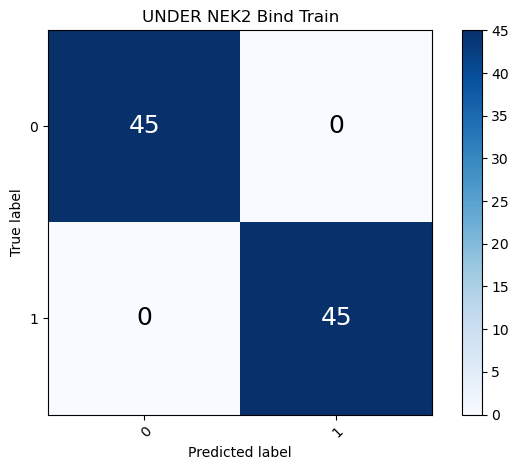

<Figure size 600x400 with 0 Axes>

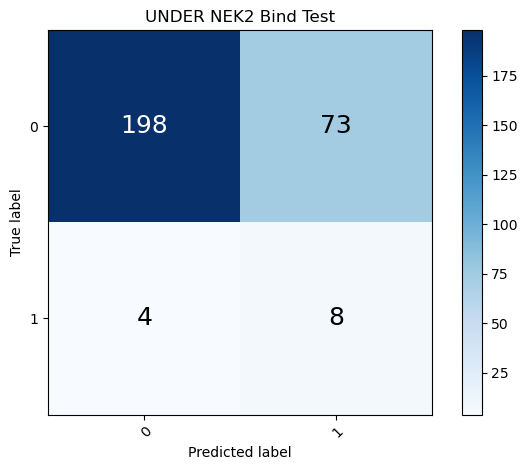

In [6]:
# get predictions of train x input
train_dist, train_observed_pred, train_pred_means, train_pred  = trainer1.predict(train_x)
train_results1 = trainer1.gp_results(train_x, train_y, 'UNDER NEK2 Bind Train')

test_dist, test_observed_pred, test_pred_means, test_pred  = trainer1.predict(test_x)
test_results1 = trainer1.gp_results(test_x, test_y, 'UNDER NEK2 Bind Test')


We will be looking at variance to measure confidence 

# Variance Distribution and Probability 
Extract variance and also sample to obtain probabilities 

In [7]:

train_observed_pred.mean.numpy()
train_pred_variance2D = train_observed_pred.variance.numpy()
# test_pred = test_observed_pred
test_observed_pred.mean.numpy()
test_pred_variance2D=test_observed_pred.variance.numpy()
var_min = test_pred_variance2D.min(axis=0).min()
var_max = test_pred_variance2D.max(axis=0).max()
var_min, var_max
# train_observed_pred.variance.numpy()
# test_observed_pred.variance.numpy()

(3.216531, 7.63751)

Extract probabilities 

In [8]:

train_pred_samples = train_dist.sample(torch.Size((256,))).exp()
train_probabilities = (train_pred_samples / train_pred_samples.sum(-2, keepdim=True)).mean(0)
train_probabilities.shape 
train_prob_stds = (train_pred_samples / train_pred_samples.sum(-2, keepdim=True)).std(0)
train_prob_stds.shape

lower, upper = test_observed_pred.confidence_region()

# # Generate samples to get probabilities
pred_samples = test_dist.sample(torch.Size((100,))).exp()
pred_samples.shape
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
prob_stds = (pred_samples / pred_samples.sum(-2, keepdim=True)).std(0)


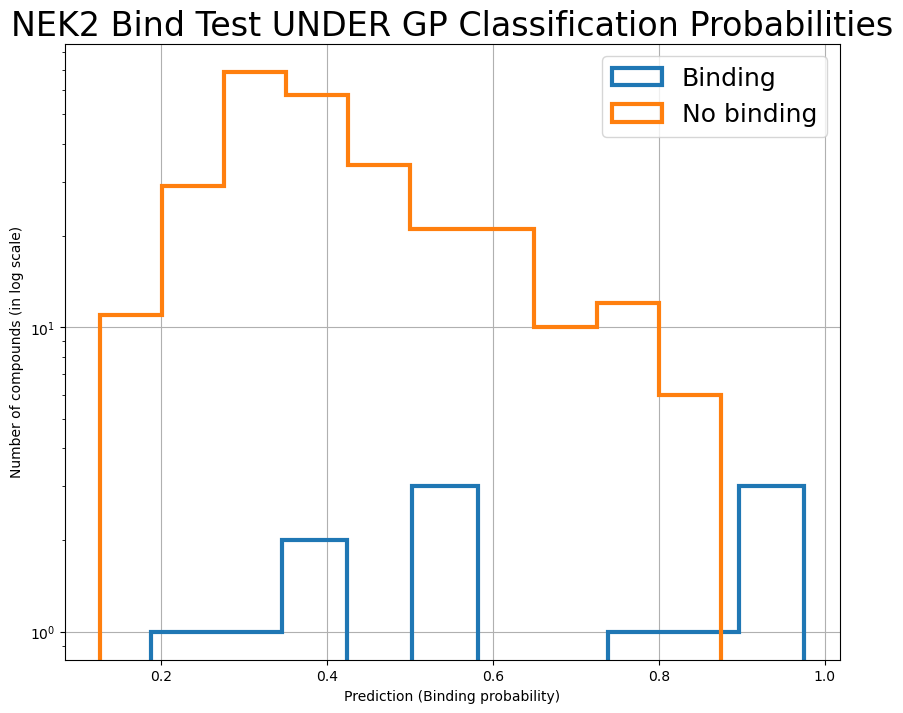

In [17]:

# plot_prob_hist(train_probabilities, train_y, 'NEK2 Bind UNDER Train GP Classification Probabilities', 'Binding')
plot_prob_hist(probabilities, test_y, 'NEK2 Bind Test UNDER GP Classification Probabilities', 'Binding')

It looks like there are overlapping probabilities. Ideally, we want better separation between the probabilities because 0 = no binding and 1 = binding.

# Look at how the variance is distributed 


/Users/jayceepang/miniconda3/envs/nek2_final/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 7.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


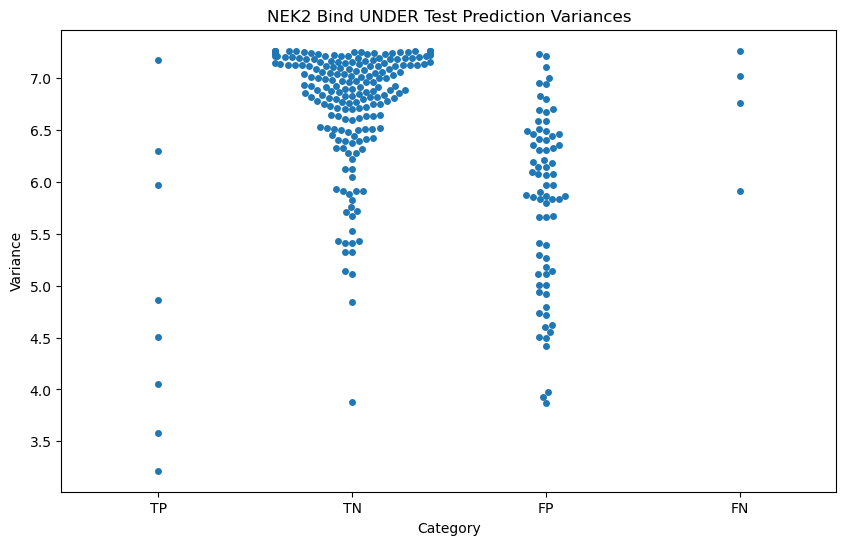

In [16]:
# plot_swarmplot(train_pred, train_y, train_observed_pred,'NEK2 Bind UNDER Train Prediction Variances')
plot_swarmplot(test_pred, test_y, test_observed_pred,'NEK2 Bind UNDER Test Prediction Variances')


Many of the predictions' variance falls at the same level, leaving no distinction between correct and incorrect predictions. However, there are more points with lower variance. It may look liek there is some points with lower variance for the true positives compared to the false positives. 

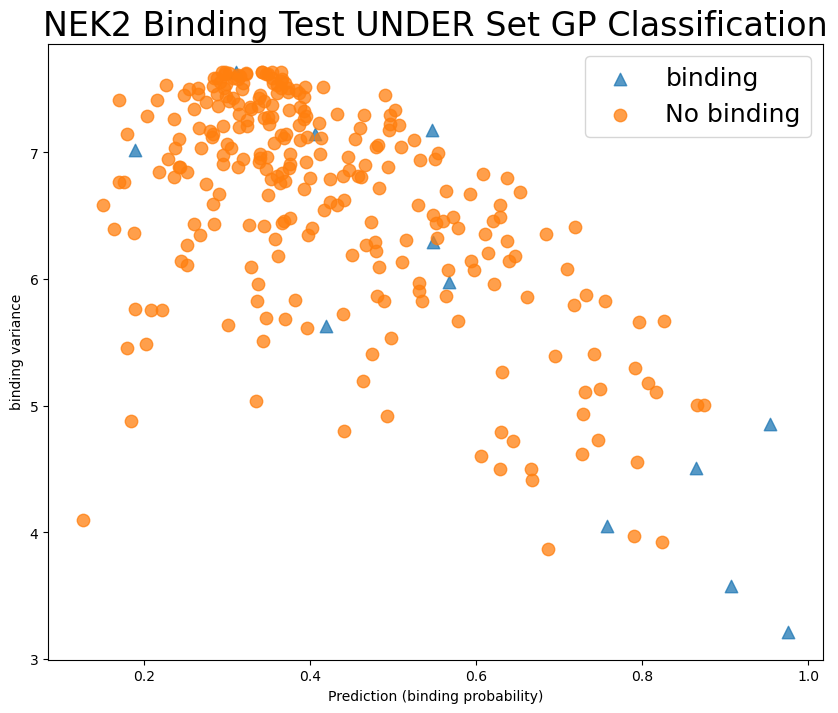

In [15]:
# probabilities_vs_var(train_y, train_probabilities, train_observed_pred,'NEK2 Bind UNDER Train Set GP Classification', 'binding')
probabilities_vs_var(test_y, probabilities, test_observed_pred,'NEK2 Binding Test UNDER Set GP Classification', 'binding')

Here, there is still no clear indication between probability and variance of whether it will be a correct or incorrect prediction. However, some binding compounds with low probability (probability closer to being inactive, with high variance) and the binding compounds with high probability have lower variance, which is an indicator of variance. Here, the main take away is that there are multiple ways to look at variance and interpret confidence or uncertainty. 

/Users/jayceepang/miniconda3/envs/nek2_final/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 7.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


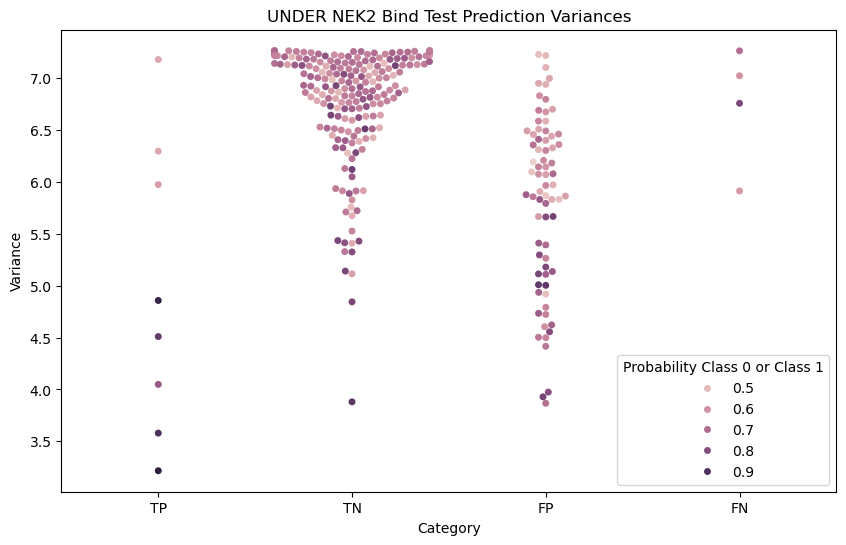

In [18]:
swarm_by_var_and_prob(test_pred, test_y, test_observed_pred,probabilities,'UNDER NEK2 Bind Test Prediction Variances')

We see this again in the plot above. At least for the TRUE positive predictions, the points wiht lower variances have higher probabilities, so the model was confident about these predicitons. As discussed in the report, these undersampled models are useful for enriching the positive predictions, so the model may make a lot of false positive predictions. 

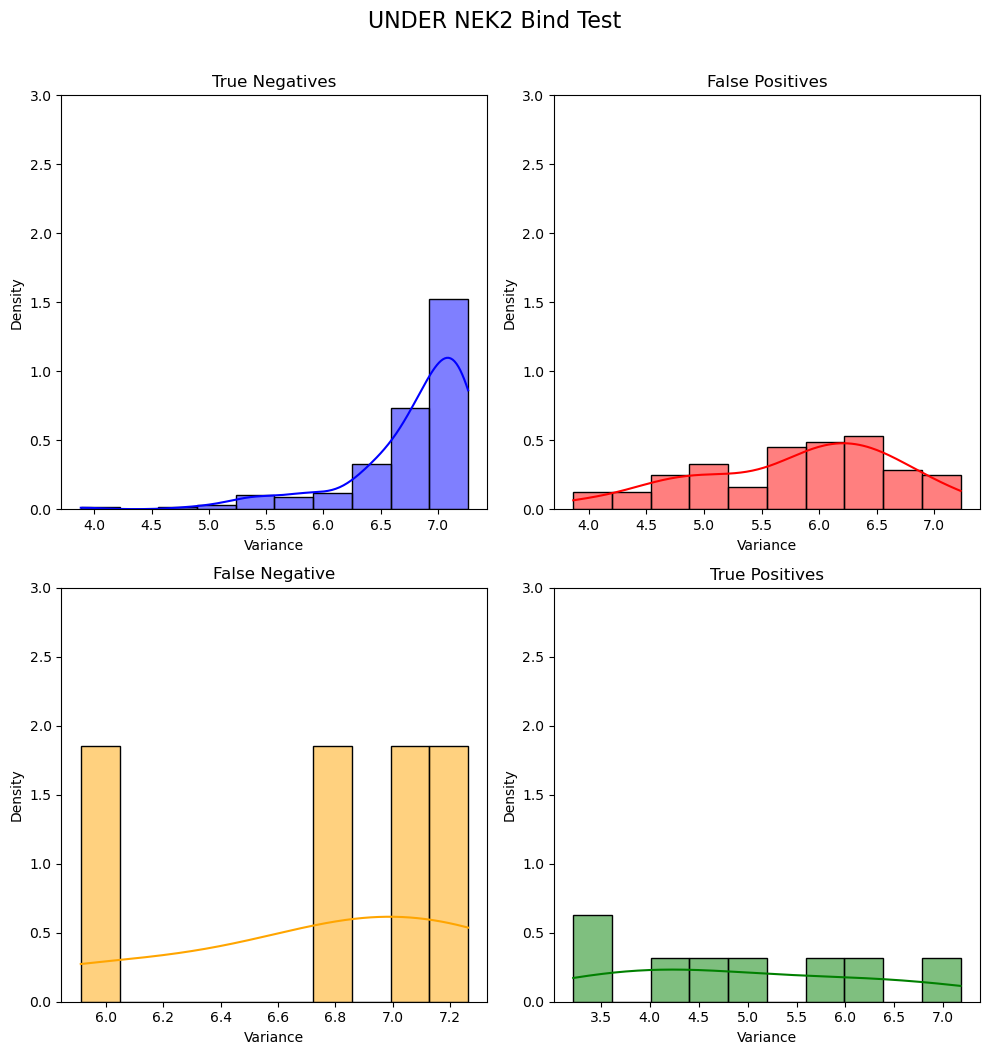

In [14]:
# plot_cm_dist_kdedensity(train_observed_pred, train_pred, train_y, 'UNDER NEK2 Bind Train',18)
plot_cm_dist_kdedensity(test_observed_pred, test_pred, test_y, 'UNDER NEK2 Bind Test',3)

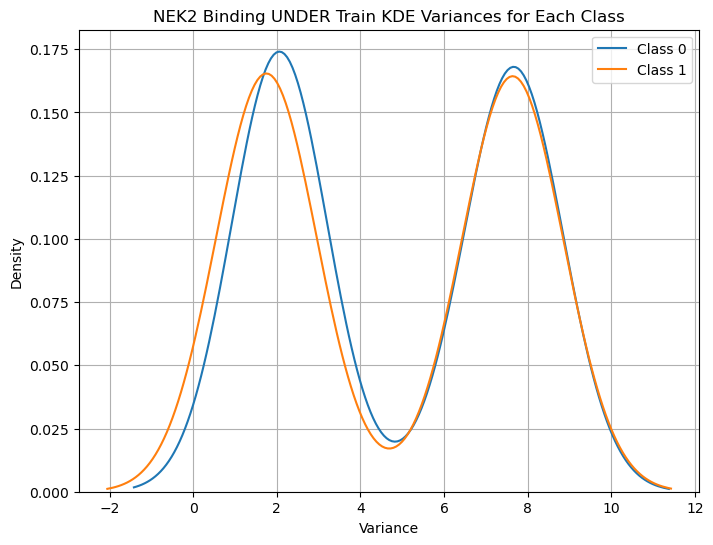

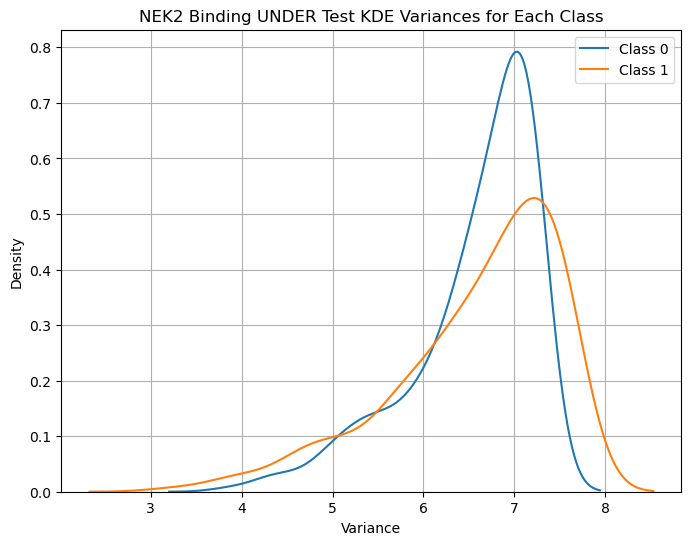

In [13]:
plot_kde(train_observed_pred, 'NEK2 Binding UNDER Train')
plot_kde(test_observed_pred, 'NEK2 Binding UNDER Test')

In [16]:
# Optionally, we can save the model performance 
train_perf_df = pd.DataFrame()
test_perf_df = pd.DataFrame()
train_perf_df['mean_pred_class0'] = train_observed_pred.mean.numpy()[0,]
train_perf_df['mean_pred_class1'] = train_observed_pred.mean.numpy()[1,]
train_perf_df['y'] = train_y
train_perf_df['y_pred'] = train_pred_means.max(0)[1]
train_perf_df['var_pred_class0']=train_observed_pred.variance.numpy()[0,]
train_perf_df['var_pred_class1']=train_observed_pred.variance.numpy()[1,]
train_perf_df['pred_prob_class0'] = train_probabilities.numpy()[0,]
train_perf_df['pred_prob_class1'] = train_probabilities.numpy()[1,]
train_perf_df['pred_prob_std_class0'] = train_prob_stds.numpy()[0,]
train_perf_df['pred_prob_std_class1'] = train_prob_stds.numpy()[1,]

test_perf_df['mean_pred_class0'] = test_observed_pred.mean.numpy()[0,]
test_perf_df['mean_pred_class1'] = test_observed_pred.mean.numpy()[1,]
test_perf_df['y'] = test_y
test_perf_df['y_pred'] = test_pred_means.max(0)[1]
test_perf_df['var_pred_class0']=test_observed_pred.variance.numpy()[0,]
test_perf_df['var_pred_class1']=test_observed_pred.variance.numpy()[1,]
test_perf_df['pred_prob_class0'] = probabilities.numpy()[0,]
test_perf_df['pred_prob_class1'] = probabilities.numpy()[1,]
test_perf_df['pred_prob_std_class0'] = prob_stds.numpy()[0,]
test_perf_df['pred_prob_std_class1'] = prob_stds.numpy()[1,]

train_perf_df.to_csv("model_performance/NEK2_bind_UNDER_train_perf.csv", index=False)
test_perf_df.to_csv("model_performance/NEK2_bind_UNDER_test_perf.csv", index=False)